# Types of coloc

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from joblib import Parallel, delayed
import os
import itertools

# load data
def load_model(gene, decompress=True, rel='../'):
    p = gene2path.get(gene)
    m = pickle.load(open(rel + p, 'rb'))
    if decompress:
        m._decompress_model()
    return m

def load_active(gene, rel='../'):
    p = gene2path.get(gene)
    m = pickle.load(open(rel + p, 'rb'))
    df = pd.DataFrame(m.active, index=m.study_ids)
    return df

def load_variant_report(gene, rel='../'):
    p = rel + gene2path.get(gene) + '.variant_report'
    df = pd.read_csv(p, sep='\t')
    return df
        
        

# generate coloc table 
def coloc_maxmin(model):
    return pd.DataFrame([{'t1': model.study_ids[i], 
      't2': model.study_ids[j], 
      'maxmin': model.active[[i, j]].min(0).max()} for i, j in combinations(range(model.dims['T']), 2)])

def coloc_topmin(model):
    # get top component for each study
    top = (
        ((model.weight_means / np.sqrt(model.weight_vars)) * model.pi[None]).sum(2) * model.active
    ).argmax(1)
    return pd.DataFrame([{
        't1': model.study_ids[i], 
        't2': model.study_ids[j],
        't1_top': top[i],
        't2_top': top[j],
        'topmin': model.active[[i, j]].min(0)[top[i]] * (top[i] == top[j])}
        for i, j in combinations(range(model.dims['T']), 2)])

def coloc_table_fn(gene):
    try:
        m = load_model(gene, decompress=True)
        a = coloc_maxmin(m)
        b = coloc_topmin(m)
        result = a.set_index(['t1','t2']).join(b.set_index(['t1','t2'])).reset_index()
        result.loc[:, 'gene'] = gene
    except Exception as e:
        result = None
    return result

def coloc_table_chunk(genes):
    return [coloc_table_fn(g) for g in genes]


#  helper
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

model_paths = np.loadtxt('../output/requests/GTEx_cafeh_genotype_ss.txt', dtype=str)
vr_paths = np.loadtxt('../output/requests/GTEx_cafeh_genotype_ss_variant_reports.txt', dtype=str)
gene2path = {p.split('/')[3]: p for p in model_paths} 

In [11]:
genes = list(gene2path.keys())
result = Parallel(n_jobs=4)(delayed(coloc_table_chunk)(g) for g in tqdm(list(chunks(genes, 100))))
Result = list(itertools.chain(*result))
Result = [g for g in Result if r is not None]

if not os.path.isfile('coloc.csv'):
    for i in tqdm(range(len(Result))):
        Result[i].to_csv('coloc.csv', mode='a', header=False)

In [3]:
p_coloc = pd.read_csv('coloc.csv', header=None, index_col=0)
p_coloc.columns = ['t1', 't2', 'maxmin', 't1_top' , 't2_top', 'topmin', 'gene']

/home-3/ktayeb1@jhu.edu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


[Text(0.5, 0, 'Proportion of Expressed Tissue Pairs')]

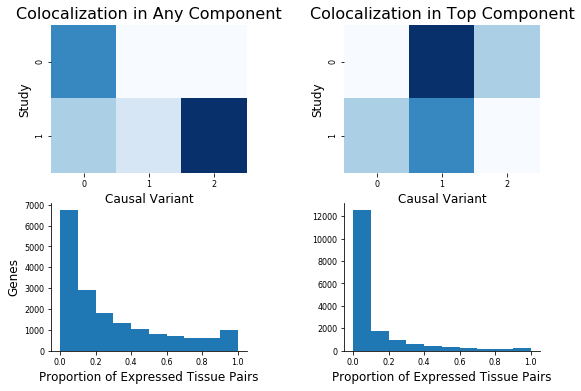

In [4]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

a = np.array([[2, 0, 0], [1, 0.5, 3]])
b = np.array([[0, 3, 1], [1, 2, 0]])
c = np.array([[3, 2, 1], [2, 1, 3]])

thresh = 0.5
p_coloc_any = p_coloc.groupby('gene').apply(lambda x: np.mean(x.maxmin > thresh))
p_coloc_top = p_coloc.groupby('gene').apply(lambda x: np.mean(x.topmin > thresh))


fig11 = plt.figure(figsize=(14, 6), constrained_layout=False)
gs = fig11.add_gridspec(2,3, wspace=0.5, hspace=0.2)

ax = plt.subplot(gs[0, 0])
sns.heatmap(a, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Any Component')

ax = plt.subplot(gs[0, 1])
sns.heatmap(b, cmap='Blues', vmin=0, vmax=3, ax=ax, cbar=False)
ax.set(xlabel = 'Causal Variant', ylabel = 'Study')
ax.set_title('Colocalization in Top Component')

ax = plt.subplot(gs[1, 0])
ax.hist(p_coloc_any[p_coloc_any >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs', ylabel='Genes')

ax = plt.subplot(gs[1, 1])
ax.hist(p_coloc_top[p_coloc_top >= 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xlabel='Proportion of Expressed Tissue Pairs')